# Word2Vec (Skipgram )

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('1.23.5', '1.13.1')

In [3]:
import matplotlib
matplotlib.__version__

'3.6.3'

## 1. Load data

In [4]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
          "dog cat animal", "cat animal dog", "cat dog animal"]

In [5]:
#1. tokenization
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [6]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [7]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index['dog']

1

In [8]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 6

In [9]:
index2word = {v:k for k, v in word2index.items()}
index2word[5]

'banana'

## 2. Prepare train data

In [10]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus):

    skipgrams = []

    #loop each corpus
    for doc in corpus:
        #look from the 2nd word until second last word
        for i in range(1, len(doc)-1):
            #center word
            center = word2index[doc[i]]
            #outside words = 2 words
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
            #for each of these two outside words, we gonna append to a list
            for each_out in outside:
                skipgrams.append([center, each_out])
                #center, outside1;   center, outside2
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)
            
x, y = random_batch(2, corpus)

In [11]:
x.shape  #batch_size, 1

(2, 1)

In [12]:
x

array([[4],
       [5]])

In [13]:
y.shape  #batch_size 1

(2, 1)

## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [14]:
len(vocabs)

7

In [15]:
embedding = nn.Embedding(7, 2)

In [16]:
x_tensor = torch.LongTensor(x)
embedding(x_tensor).shape  #(batch_size, 1, emb_size)

torch.Size([2, 1, 2])

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

In [17]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)  #(batch_size, 1, emb_size)
        outside_embedding    = self.embedding_center(outside) #(batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_center(all_vocabs) #(batch_size, voc_size, emb_size)
        
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        #batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1) 

        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        #batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size) 
        
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)
        
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  #scalar
        
        return loss
        

In [18]:
#prepare all vocabs

batch_size = 2
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])

In [19]:
model = Skipgram(voc_size, 2)
model

Skipgram(
  (embedding_center): Embedding(7, 2)
  (embedding_outside): Embedding(7, 2)
)

In [20]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [21]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [22]:
loss

tensor(2.1104, grad_fn=<NegBackward0>)

## 4. Training

In [23]:
batch_size = 2
emb_size   = 2
model      = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [25]:
num_epochs = 10000

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    #predict
    loss = model(input_tensor, label_tensor, all_vocabs)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

Epoch   1000 | Loss: 1.121964
Epoch   2000 | Loss: 1.064507
Epoch   3000 | Loss: 1.085544
Epoch   4000 | Loss: 1.111461
Epoch   5000 | Loss: 1.073724
Epoch   6000 | Loss: 1.074697
Epoch   7000 | Loss: 1.075899
Epoch   8000 | Loss: 1.109935
Epoch   9000 | Loss: 1.113808
Epoch  10000 | Loss: 1.121020


## 5. Plot the embeddings

Is fruit really near to banana?
Is fruit really far from cat?

In [26]:
vocabs

['apple', 'dog', 'cat', 'animal', 'fruit', 'banana', '<UNK>']

In [27]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([5])

In [32]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)
banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed

tensor([[ 0.4169, -0.1962]], grad_fn=<DivBackward0>)

In [31]:
banana_embed_o

tensor([[-0.8438, -0.9700]], grad_fn=<EmbeddingBackward0>)

In [33]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [34]:
get_embed('fruit')

(1.6790380477905273, 0.626070499420166)

In [35]:
get_embed('cat')

(-0.9120234251022339, -0.8405683636665344)

In [38]:
get_embed('dog')

(-0.5287396907806396, -1.080083966255188)

In [37]:
get_embed('banana')

(0.41691577434539795, -0.19619107246398926)

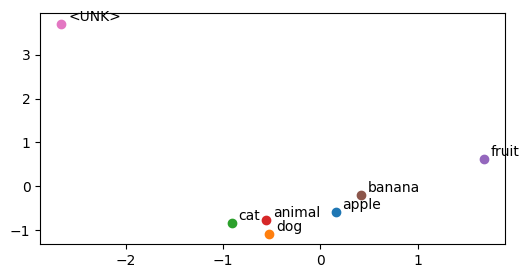

In [39]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

In [40]:
banana = get_embed('banana')
banana

(0.41691577434539795, -0.19619107246398926)

In [42]:
fruit = get_embed('fruit')
fruit

(1.6790380477905273, 0.626070499420166)

In [48]:
unk = get_embed('<UNK>')
unk

(-2.6585030555725098, 3.7024025917053223)

In [49]:
np.array(banana) @ np.array(unk)

-1.83475019517374

In [53]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(banana), np.array(unk)))
print(cosine_similarity(np.array(banana), np.array(fruit)))

-0.8736089652227542
0.6990419353658858
